In [10]:
import torch
import functions_data
import os 
import functions_ordinal
import functions_plotting
import seaborn as sns
import matplotlib.pyplot as plt 
from torch import optim
import tqdm
from scipy.stats import entropy
import pandas as pd 

from functions_test_manipulations import get_merged_test_and_dict, get_dictionary, get_large_dataset
import numpy as np 

#  Functions

In [11]:
# select the number of students to train question parameters (and student parameters - for old students)
def convert_dataframe_to_triples(data):
    """
    input - data: dataframe of dimensions n_students x n_questions 
    returns tensor of dimensions ((n_students*n_questions), 3)
    where first n_questions rows correspond to student 1, next n_questions rows correspond to student 3, etc. 
    """
    data = data.astype('float')
    data_tensor = torch.tensor(data.values)
    n_students, n_questions = data_tensor.shape[0], data_tensor.shape[1]

    data_tensor = data_tensor.reshape(-1)

    student_id = torch.arange(1, n_students + 1)
    student_id = student_id.repeat_interleave(n_questions)

    questions_in_order = data.columns
    question_id = []
    for q in questions_in_order:
        question_id.append(int(q[1:]))

    question_id = torch.tensor(question_id)
    
    # question_id = torch.arange(1, n_questions + 1)
    question_id = question_id.repeat(n_students)
    return torch.stack((student_id, question_id, data_tensor), dim=1)

#  Load data for all three exams

In [12]:
_, meta_dict = get_large_dataset()

/Users/anastasijailic/Library/Mobile Documents/com~apple~CloudDocs/Master/functions_test_manipulations.py:135: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_filepath, index_col=0)


In [13]:
test_names = ['9to1_Edexcel_GCSE_Nov2018_1H', '9to1_Edexcel_GCSE_Nov2018_2H', 
'9to1_Edexcel_GCSE_Nov2018_3H']
data, questions_info, IDs  = get_merged_test_and_dict(test_names)

/Users/anastasijailic/Library/Mobile Documents/com~apple~CloudDocs/Master/functions_test_manipulations.py:98: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_filepath, index_col=0)


In [14]:
n_questions_first_exam = len(get_dictionary(meta_dict, test_names[0]))
n_questions_second_exam = len(get_dictionary(meta_dict, test_names[1]))
n_questions_third_exam = len(get_dictionary(meta_dict, test_names[2]))

In [15]:
# data_path = os.path.join(os.getcwd(), 'data', 'three_exams_cleaned.csv')
# dict_path = os.path.join(os.getcwd(), 'data', 'questions_info_dict.p')
# data, questions_info = functions_data.load_data_and_dictionary(data_path, dict_path)

n_students, n_questions = data.shape[0], data.shape[1]

# if the score is higher than max score for the given question, put score = max_score 
for col in data:
    m = questions_info[col]['Max']
    data[col].loc[data[col] > m] = m

# rename keys in the questions_info 
new_dictionary = {}
columns_mapper = {}
dict_keys = questions_info.keys()
for ind, key_old in enumerate(dict_keys):
    key_new = 'q' + str(ind + 1)
    new_dictionary[key_new] = questions_info[key_old]
    columns_mapper[key_old] = key_new 

# rename column in the dataframe
data = data.rename(columns=columns_mapper)

max_score = int(data.values.max())

In [16]:
# Separate learning and pooling dataframe 
# training_students = 13563
training_students = int(0.7*data.shape[0])
pooling_students = data.shape[0] - training_students

training_dataframe = data[:training_students]
pooling_dataframe = data[training_students:]

#  Pretrain parameters just using data from the first and last exam

In [17]:
n_students, n_questions = training_dataframe.shape[0], training_dataframe.shape[1]

training_tensor = torch.tensor(training_dataframe.astype('float').values)
max_score = int(training_tensor.max().numpy())

# select just the first and last exam in the training_dataframe to train on 
questions = list(training_dataframe.columns)
first_and_third_exam_questions = questions[:n_questions_first_exam] + questions[-n_questions_third_exam:]
no_second_exam_dataframe = training_dataframe[first_and_third_exam_questions]

tensor_training = torch.tensor(no_second_exam_dataframe.astype('float').values)
max_score = int(tensor_training.max().numpy())

train_data, validation_data, test_data = functions_ordinal.separate_train_validation_test_data(tensor_training)

train_data_max_scores = functions_ordinal.generate_max_scores_tensor(train_data, questions_info)
test_data_max_scores = functions_ordinal.generate_max_scores_tensor(test_data, questions_info)
validation_data_max_scores = functions_ordinal.generate_max_scores_tensor(validation_data, questions_info)

# initialization of parameters 
bs_pretrained = torch.randn(n_students, requires_grad=True)
bq0_pretrained = torch.distributions.uniform.Uniform(0,1).sample([n_questions,])
rho_pretrained = torch.normal(0, 0.1, size = (n_questions, max_score - 1), requires_grad=True) # rho1, rho2, rho3 

bq0_pretrained.requires_grad = True  


nlls_train = []
nlls_validation = []
nlls_test = []

iterations = 4000
params = [bs_pretrained, bq0_pretrained, rho_pretrained]

#  Pretraining

In [18]:
opt = optim.SGD(params, lr = 0.0001)

for iter in range(iterations):
    loss = functions_ordinal.nll(train_data, params, max_score, train_data_max_scores)    
    opt.zero_grad()
    loss.backward()
    opt.step()
    nlls_train.append(loss.detach().numpy())

    loss_validation = functions_ordinal.nll(validation_data, params, max_score, validation_data_max_scores)
    loss_test = functions_ordinal.nll(test_data, params, max_score, test_data_max_scores)

    nlls_validation.append(loss_validation.detach().numpy())
    nlls_test.append(loss_test.detach().numpy())

    if iter % 100 == 0:
        print(iter)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900


#  Separate learning pool and testing pool for active learning 

In [19]:
questions = list(pooling_dataframe.columns)
n_questions_first_second_test = n_questions - n_questions_third_exam
learning_questions = questions[:n_questions_first_exam]
testing_questions = questions[-n_questions_third_exam:] # testing questions are now the entire exam (third one)

# number of questions in the learning pool and testing pool 
n_learning_pool = len(learning_questions)
n_testing_pool = len(testing_questions)

learning_pool_df = pooling_dataframe[learning_questions]
testing_pool_df = pooling_dataframe[testing_questions]

learning_pool = convert_dataframe_to_triples(learning_pool_df)
testing_pool = convert_dataframe_to_triples(testing_pool_df)

learning_pool_max_scores = functions_ordinal.generate_max_scores_tensor(learning_pool, new_dictionary)
testing_pool_max_scores = functions_ordinal.generate_max_scores_tensor(testing_pool, new_dictionary)

# Retrain parameters on the entire learning pool 

In [20]:
# number of students in the learning pool 
S_learning_pool = pooling_students # could also be init as learning_pool_df.shape[0]
Q_learning_pool = n_learning_pool # learning_pool_df.shape[0]

bs_pool = torch.randn(S_learning_pool, requires_grad=True)
# bs_pool = torch.repeat_interleave(bs_pretrained.detach().mean(), S_learning_pool)
bs_pool.requires_grad = True
bq0_pool = bq0_pretrained.detach().clone()
rho_pool = rho_pretrained.detach().clone()


# calculate initial accuracy with randomly assigned bs 
active_learning_iterations = Q_learning_pool 
initial_accuracy = 0 

prob_matrix = functions_ordinal.generate_prob_matrix(testing_pool, bs_pool, bq0_pool, rho_pool, max_score, testing_pool_max_scores)
predicted_scores = prob_matrix.argmax(axis = 1)
true_scores = testing_pool[:, 2]

initial_accuracy = functions_ordinal.full_accuracy(true_scores, predicted_scores).numpy()
print('Accuracy before training ', initial_accuracy)

# def retrain_parameters(data, data_max_scores, bs_pool, bq0_pool, rho_pool, max_score, loss_, it):
iterations = 5000 

bq0_pool.requires_grad = False 
rho_pool.requires_grad = False

params = [bs_pool, bq0_pool, rho_pool]
opt = optim.SGD(params, lr = 0.0001)
n = learning_pool.shape[0]
loss_random_init = []
accuracies_random_init = []

for iter in range(iterations):
    loss = functions_ordinal.nll(learning_pool, params, max_score, learning_pool_max_scores)
    opt.zero_grad()
    loss.backward()
    opt.step()
    loss_random_init.append(loss/n)


    prob_matrix = functions_ordinal.generate_prob_matrix(testing_pool, bs_pool, bq0_pool, rho_pool, max_score, testing_pool_max_scores)
    predicted_scores = prob_matrix.argmax(axis = 1)
    true_scores = testing_pool[:, 2]
    
    accuracies_random_init.append(functions_ordinal.full_accuracy(true_scores, predicted_scores).numpy())

    if iter % 100 == 0:
        print(iter, loss)


Accuracy before training  0.44277075
0 tensor(129172.1484, grad_fn=<NegBackward0>)
100 tensor(125216.4531, grad_fn=<NegBackward0>)
200 tensor(121657.5625, grad_fn=<NegBackward0>)
300 tensor(118465.0938, grad_fn=<NegBackward0>)
400 tensor(115609.2188, grad_fn=<NegBackward0>)
500 tensor(113061.0469, grad_fn=<NegBackward0>)
600 tensor(110792.8047, grad_fn=<NegBackward0>)
700 tensor(108778.0625, grad_fn=<NegBackward0>)
800 tensor(106991.8750, grad_fn=<NegBackward0>)
900 tensor(105410.9453, grad_fn=<NegBackward0>)
1000 tensor(104013.6094, grad_fn=<NegBackward0>)
1100 tensor(102779.9297, grad_fn=<NegBackward0>)
1200 tensor(101691.7031, grad_fn=<NegBackward0>)
1300 tensor(100732.3359, grad_fn=<NegBackward0>)
1400 tensor(99886.9219, grad_fn=<NegBackward0>)
1500 tensor(99142.0234, grad_fn=<NegBackward0>)
1600 tensor(98485.6797, grad_fn=<NegBackward0>)
1700 tensor(97907.2188, grad_fn=<NegBackward0>)
1800 tensor(97397.2109, grad_fn=<NegBackward0>)
1900 tensor(96947.3438, grad_fn=<NegBackward0>)
2

Text(0.5, 1.0, 'Training for new students in the learning pool')

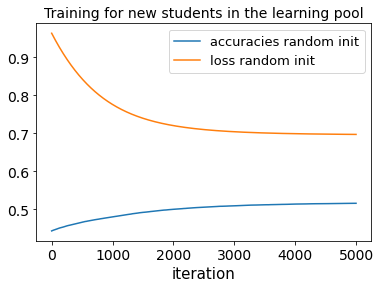

In [21]:
loss_random_init = [x.detach().numpy() for x in loss_random_init]
plt.plot(accuracies_random_init, label ='accuracies random init')
plt.plot(loss_random_init, label = 'loss random init')

# plt.plot(accuracies_mean_bs_initialisation, label ='accuracies mean init')
# plt.plot(loss_mean_bs_init, label = 'loss mean init')

plt.legend(fontsize=13)
plt.xlabel('iteration', size = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Training for new students in the learning pool', fontsize=14)

#  Mean prediction for each student on the heldout exam

In [22]:
prob_matrix = functions_ordinal.generate_prob_matrix(testing_pool, bs_pool, bq0_pool, rho_pool, max_score, testing_pool_max_scores)
predicted_scores = prob_matrix.argmax(axis = 1)
true_scores = testing_pool[:, 2]
scores_matrix = torch.tensor(list(np.arange(0, max_score + 1, 1))).repeat(prob_matrix.shape[0], 1)
expected_value_matrix = torch.mul(prob_matrix, scores_matrix) 
predicted_expected_value_scores = expected_value_matrix.sum(axis = 1)

In [23]:
df = pd.DataFrame(testing_pool.numpy(), columns=['studentID', 'questionID', 'score'])
df['thresh_predicted_score'] = predicted_scores
df['mean_predicted_score'] = predicted_expected_value_scores.detach().numpy()

df_sum = df.groupby(['studentID']).sum()

In [24]:
print('Accuracy on the testing pool ', (df['thresh_predicted_score'] == df['score']).astype(int).sum()/df.shape[0])

Accuracy on the testing pool  0.5156680194159307


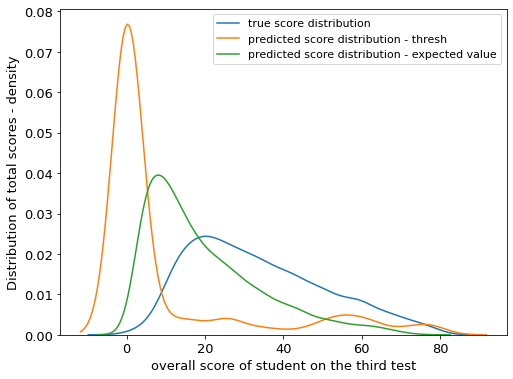

In [36]:
plt.figure(figsize=(8, 6))
sns.kdeplot(df_sum.score, label = 'true score distribution')
sns.kdeplot(df_sum.thresh_predicted_score, label = 'predicted score distribution - thresh')
sns.kdeplot(df_sum.mean_predicted_score, label = 'predicted score distribution - expected value')
plt.legend(fontsize = 11)
plt.xlabel('overall score of student on the third test', fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylabel('Distribution of total scores - density', fontsize = 13)
plt.show()

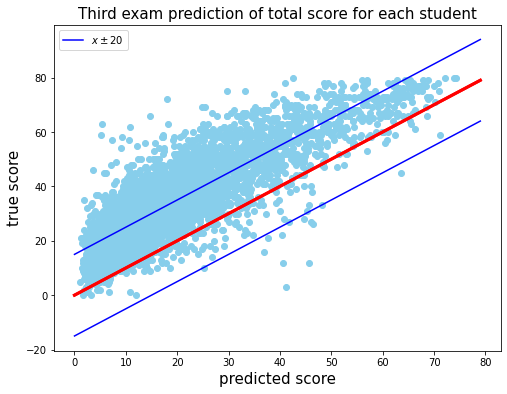

In [37]:
true_scores = torch.tensor(df_sum['score'].values)
student_ids = df_sum.index.to_numpy()
predicted_scores = torch.tensor(df_sum['mean_predicted_score'].values)
diff = true_scores - predicted_scores
n_students_selected = 5000
plt.figure(figsize=(8, 6))
plt.scatter(predicted_scores, true_scores, color='skyblue')
plt.xlabel('predicted score', size = 15)
plt.ylabel('true score', size = 15)
x = np.arange(0,80)
plt.plot(x, x, color='r', linewidth = 3)
plt.plot(x, x, color='r', linewidth = 3)
plt.plot(x, x-15, color = 'b')
plt.plot(x, x+15, color = 'b', label = r'$x \pm 20$')
plt.legend()

plt.title('Third exam prediction of total score for each student', size=15)
plt.show()

#  Retrain parameters including the second test 

In [26]:
questions = list(pooling_dataframe.columns)
n_questions_first_second_test = n_questions - n_questions_third_exam
learning_questions = questions[:n_questions_first_exam]
testing_questions = questions[-n_questions_third_exam:] # testing questions are now the entire exam (third one)

# number of questions in the learning pool and testing pool 
n_learning_pool = len(learning_questions)
n_testing_pool = len(testing_questions)

learning_pool_df = pooling_dataframe[learning_questions]
testing_pool_df = pooling_dataframe[testing_questions]

learning_pool = convert_dataframe_to_triples(learning_pool_df)
testing_pool = convert_dataframe_to_triples(testing_pool_df)

learning_pool_max_scores = functions_ordinal.generate_max_scores_tensor(learning_pool, new_dictionary)
testing_pool_max_scores = functions_ordinal.generate_max_scores_tensor(testing_pool, new_dictionary)

In [34]:
print(bs_retrain)

tensor([-2.1837, -3.6924, -0.8758,  ...,  0.2920,  0.8025, -0.0972],
       grad_fn=<CloneBackward0>)


In [35]:
print(bs_pool)

tensor([-2.2230, -3.7398, -0.8666,  ...,  0.2899,     nan, -0.1244],
       requires_grad=True)


In [31]:
# new learning pool is just second exam to inform the model more about student's ability 
questions = list(pooling_dataframe.columns)
learning_questions = questions[:n_questions_first_exam + n_questions_second_exam]

learning_pool_df = pooling_dataframe[learning_questions]

learning_pool = convert_dataframe_to_triples(learning_pool_df)
learning_pool_max_scores = functions_ordinal.generate_max_scores_tensor(learning_pool, new_dictionary)


# accuracy on the test set pre-pre training the model 
prob_matrix = functions_ordinal.generate_prob_matrix(testing_pool, bs_pool, bq0_pool, rho_pool, max_score, testing_pool_max_scores)
predicted_scores = prob_matrix.argmax(axis = 1)
true_scores = testing_pool[:, 2]

initial_accuracy = functions_ordinal.full_accuracy(true_scores, predicted_scores).numpy()
print('Accuracy before training ', initial_accuracy)

bs_retrain = bs_pool.clone()
bq0_retrain = bq0_pool.clone()
rho_retrain = rho_pool.clone()

iterations = 5000 
params = [bs_pool, bq0_pool, rho_pool]
opt = optim.SGD(params, lr = 0.0001)
new_loss = []
new_accuracies = []

n = learning_pool.shape[0]

for iter in range(iterations):
    loss = functions_ordinal.nll(learning_pool, params, max_score, learning_pool_max_scores)
    opt.zero_grad()
    loss.backward()
    opt.step()
    new_loss.append(loss/n)


    prob_matrix = functions_ordinal.generate_prob_matrix(testing_pool, bs_pool, bq0_pool, rho_pool, max_score, testing_pool_max_scores)
    predicted_scores = prob_matrix.argmax(axis = 1)
    true_scores = testing_pool[:, 2]
    
    new_accuracies.append(functions_ordinal.full_accuracy(true_scores, predicted_scores).numpy())

    if iter % 100 == 0:
        print(iter, loss)


Accuracy before training  0.51566803
0 tensor(inf, grad_fn=<NegBackward0>)


KeyboardInterrupt: 

In [33]:
print(learning_pool.shape)
print(len(learning_pool_max_scores))

torch.Size([242962, 3])
242962
